In [1]:
import stokespy
from stokespy import get_HMI_data, get_SP_data, StokesParamCube, StokesParamMap, StokesProfile
import datetime
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, SpectralCoord
from astropy.wcs.wcsapi import SlicedLowLevelWCS, HighLevelWCSWrapper

from sunpy.image import coalignment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ndcube

from scipy import ndimage

matplotlib.use('TkAgg')

import warnings
warnings.filterwarnings('ignore')

# Setup the autoreload function.
%load_ext autoreload
%autoreload 2

In [2]:
def get_image_shift(image1, image2):
    # slightly modified code snippet from bitbucket to determine the shift
    # between two images using FFT:
    
    # discrete fast fourier transformation and complex conjugation of image2 
    image1FFT = np.fft.fft2(image1)
    image2FFT = np.conjugate( np.fft.fft2(image2) )

    # inverse fourier transformation of product -> equal to cross correlation
    imageCCor = np.real( np.fft.ifft2( (image1FFT*image2FFT) ) )

    # shift the zero-frequency component to the center of the spectrum
    imageCCorShift = np.fft.fftshift(imageCCor)

    # determine the distance of the maximum from the center
    row, col = image1.shape

    yshift, xshift = np.unravel_index( np.argmax(imageCCorShift), (row,col) )

    xshift -= int(col/2)
    yshift -= int(row/2)

    return xshift, yshift

# Load SDO/HMI data series

In [3]:
# Select a date and time to search for observations.
#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')  # Original
#user_date = astropy.time.Time(datetime.datetime(2017, 8, 22, 17, 11, 4), scale='tai')  # AR near limb
user_date = astropy.time.Time(datetime.datetime(2017, 9, 5, 3, 4, 4), scale='tai')  # AR near disc center

# Find the nearest set of Stokes and corresponding inversion results.
#all_fnames_stokes, all_fnames_magvec = get_HMI_data(user_date, user_notify='gdima@hawaii.edu', download=False)
lvl1_data, lvl1_wcs, lvl2_data, lvl2_wcs = \
    get_HMI_data(user_date, user_notify='gdima@hawaii.edu', 
                 download=False, show_files=False, derotate=True)

Time window used for the search:  <sunpy.net.attrs.Time(2017-09-05 03:04:03.000, 2017-09-05 03:04:05.000)>
User directory pointing to SDO data is not included.
Setting the default directory to: /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/SDO/
No download requested. Found 24 Stokes files with unique timestamp(s):
['20170905_030000_TAI']
No download requested. Found 25 inversion files with timestamps: 
['20170905_030000_TAI']
OBS: Derotating each image
Created Stokes data cube with dimensions: (4, 6, 4098, 4098)
OBS: Derotating each magnetic field image.
Created magnetic field data cube with dimensions: (3, 4098, 4098)


In [4]:
# Create the HMI Cubes
lvl1_c_HMI = stokespy.StokesCube(lvl1_data, lvl1_wcs)
lvl2_c_HMI = stokespy.MagVectorCube(lvl2_data, lvl2_wcs)
print('HMI Stokes data shape: ', lvl1_c_HMI.data.shape)
print('HMI magnetic data shape: ', lvl2_c_HMI.data.shape)

HMI Stokes data shape:  (4, 6, 4098, 4098)
HMI magnetic data shape:  (3, 4098, 4098)


In [8]:
# Information from the WCS attached to the cubes.
# Note the index ordering is different between the data array and the header information.
# 
lvl1_c_HMI.wcs,lvl2_c_HMI.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.0  0.0  6.173345e-07  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  3.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  7.4040177438477e-22  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 7.4040177438477e-22  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  6.88e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.0  0.0  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
 PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  1.0  
 NAXIS : 0  0)

# Load Hinode/SP data series

In [6]:
# Select a date and time to search for observations.
#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')
#user_date = '20201101_200602'  # Quiet Sun
#user_date = '20170822_171104'   # AR near limb
user_date = '20170905_030404'  # AR near disc center

# Find the nearest set of Stokes and corresponding inversion results.
#all_fnames_stokes, all_fnames_magvec = get_HMI_data(user_date, user_notify='gdima@hawaii.edu', download=False)
magnetic_params=['Field_Strength', 
                 'Field_Inclination', 
                 'Field_Azimuth',
                 'Stray_Light_Fill_Factor']
head_all, head1, head2, lvl1_data, lvl1_wcs, lvl2_data, lvl2_wcs = \
    get_SP_data(user_date, magnetic_params=magnetic_params)

In [7]:
# Create the Hinode StokesCube
lvl1_c_SP = stokespy.StokesCube(lvl1_data, lvl1_wcs)
lvl2_c_SP = stokespy.MagVectorCube(lvl2_data, lvl2_wcs, magnetic_params=magnetic_params)
print('SP Stokes cube shape: ', lvl1_c_SP.data.shape)
print('SP magnetic cube shape: ', lvl2_c_SP.data.shape)

SP Stokes cube shape:  (4, 112, 512, 485)
SP magnetic cube shape:  (4, 512, 485)


In [9]:
# Information from the WCS attached to the cube.
# Note the index ordering is different between the data array and the header information.
# 
lvl1_c_SP.wcs, lvl2_c_SP.wcs, lvl2_c_SP.magnetic_axis

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0,
 ['Field_Strength',
  'Field_Inclination',
  'Field_Azimuth',
  'Stray_Light_Fill_Factor'])

In [10]:
lvl1_c_SP.spectral_axis.to(u.nm)

<Quantity [630.08840305, 630.09055795, 630.09271285, 630.09486775,
           630.09702265, 630.09917755, 630.10133245, 630.10348735,
           630.10564225, 630.10779715, 630.10995205, 630.11210695,
           630.11426185, 630.11641675, 630.11857165, 630.12072655,
           630.12288145, 630.12503635, 630.12719125, 630.12934615,
           630.13150105, 630.13365595, 630.13581085, 630.13796575,
           630.14012065, 630.14227555, 630.14443045, 630.14658535,
           630.14874025, 630.15089515, 630.15305005, 630.15520495,
           630.15735985, 630.15951475, 630.16166965, 630.16382455,
           630.16597945, 630.16813435, 630.17028925, 630.17244415,
           630.17459905, 630.17675395, 630.17890885, 630.18106375,
           630.18321865, 630.18537355, 630.18752845, 630.18968335,
           630.19183825, 630.19399315, 630.19614805, 630.19830295,
           630.20045785, 630.20261275, 630.20476765, 630.20692255,
           630.20907745, 630.21123235, 630.21338725, 630.21554

In [11]:
lvl1_c_SP.wcs.world_axis_units

['deg', 'deg', 'm', '']

## Test the image central coordinates

In [11]:
# The wcs contructor converts inputs into 'deg' and 'm'.
# This number is comparable to the values using
print('Spatial sampling along X (arcsec): ', \
      lvl1_wcs.wcs.cdelt[0]*u.deg.to(u.arcsec), 151/512)

print('Spatial sampling along Y (arcsec): ', \
      lvl1_wcs.wcs.cdelt[1]*u.deg.to(u.arcsec), 162/511)

print('Level1 FOV center coordinates (x,y)[arcsec] = :',\
      lvl1_wcs.wcs.crval[0]*u.deg.to(u.arcsec), \
      lvl1_wcs.wcs.crval[1]*u.deg.to(u.arcsec))

print('Level2 FOV center coordinates (x,y)[arcsec] = :',\
      lvl2_wcs.wcs.crval[0]*u.deg.to(u.arcsec), \
      lvl2_wcs.wcs.crval[1]*u.deg.to(u.arcsec))


Spatial sampling along X (arcsec):  0.29714 0.294921875
Spatial sampling along Y (arcsec):  0.319978 0.31702544031311153
Level1 FOV center coordinates (x,y)[arcsec] = : 129.963 40.598
Level2 FOV center coordinates (x,y)[arcsec] = : 129.963 40.598


WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
CRPIX : 243.0  256.5  56.5  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 8.253888888888889e-05  8.888277777777778e-05  2.1549e-12  1.0  
NAXIS : 0  0

In [14]:
lvl1_c_SP.frame

<Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (58.05512713, -41.15637222)>

In [15]:
print(head1['XCEN'], head2['XCEN'], head1['YCEN'],head2['YCEN'])

55.8102 96.301 40.8188 40.5247


In [16]:
print(head1['XSCALE'], head2['XSCALE'], head1['YSCALE'],head2['YSCALE'])

0.297140002251 0.29714 0.319979995489 0.319978


In [17]:
print(head1['NAXIS1'], head2['NAXIS1'], head1['NAXIS2'], head2['NAXIS2'])

112 485 512 512


In [18]:
lv1_wcs.wcs.crpix

array([243. , 256.5,  56.5,   0. ])

In [19]:
# Look at the centeral position for each header.
nslit = len(head_all)
xcen_a = np.zeros(nslit)
ycen_a = np.zeros(nslit)

for i in range(nslit):
    xcen_a[i] = head_all[i]['XCEN']
    ycen_a[i] = head_all[i]['YCEN']

In [20]:
%matplotlib widget

plt.plot(xcen_a, label='Xcen')
plt.plot(ycen_a, label='Ycen')
print(np.median(xcen_a), np.median(ycen_a))
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

129.963 40.598


# Co-align Hinode and HMI observations

## Align level1 images

In [ ]:
### Hinode data ###

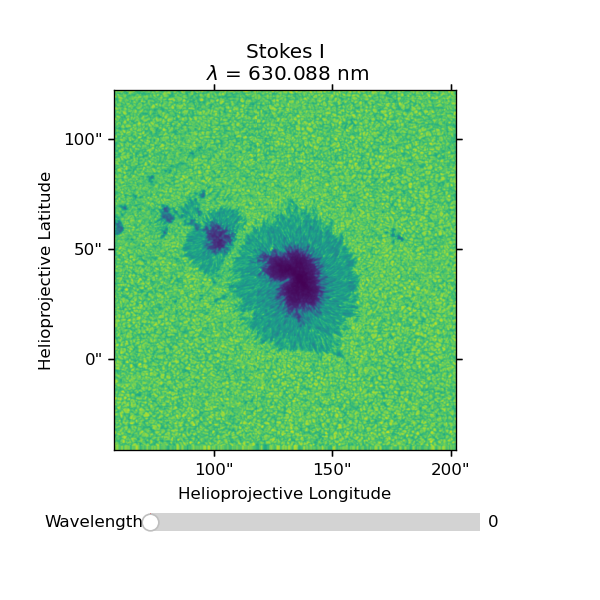

In [107]:
# First we can look at how the images look at each wavelength.
%matplotlib widget

I_cube_SP = lvl1_c_SP.I
I_cube_SP.plot()

In [15]:
# We can select the wavelength near index 48 as a good continuum location.
wav_ind = 48
print(lvl1_c_SP.spectral_axis[wav_ind].to(u.nm))

630.1918382499999 nm


In [16]:
SP_img = lvl1_c_SP.data[0,wav_ind,:,:]
print(SP_img.shape)

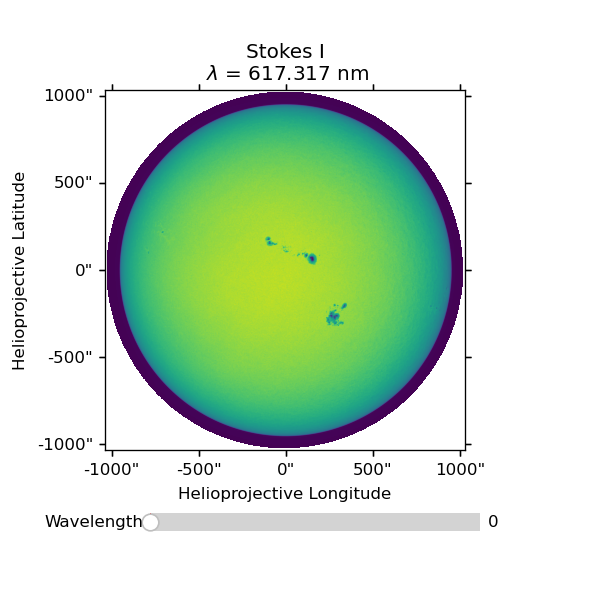

In [108]:
### Select a continuum location from HMI

# First we can look at how the images look at each wavelength.
%matplotlib widget

I_cube_HMI = lvl1_c_HMI.I
I_cube_HMI.plot()

In [19]:
HMI_img = lvl1_c_HMI.data[0,0,:,:]

In [22]:
# To determine the offset between the Hinode and HMI images we need to run a cross-correration
# To do this we need to crop the HMI image to include the Hinode area together with a border.

### Coordinates ###
# HINODE_YCOORDS
x_min, x_max = lvl1_c_SP.coord2_axis(0)[0].Tx.to(u.deg), lvl1_c_SP.coord2_axis(0)[-1].Tx.to(u.deg)
y_min, y_max = lvl1_c_SP.coord1_axis(0)[0].Ty.to(u.deg), lvl1_c_SP.coord1_axis(0)[-1].Ty.to(u.deg)

print(x_min.to(u.arcsec), x_max.to(u.arcsec))
print(y_min.to(u.arcsec), y_max.to(u.arcsec))

58.0551arcsec 201.871arcsec
-41.1564arcsec 122.352arcsec
58.0551arcsec 201.871arcsec
-41.1564arcsec 122.352arcsec


In [23]:
### Calculate the corresponding pixel indices in the HMI WCS.
hmi_index_y, hmi_index_x = \
lvl1_c_HMI[0,0,:,:].wcs.low_level_wcs.world_to_array_index_values([x_min.value, x_max.value], [y_min.value, y_max.value])
print(hmi_index_y, hmi_index_x)

[1965 2289] [2172 2457]


In [115]:
### Create a cropped HMI map at the approximate coordinates.
pix_pad = 120
HMI_img_pad = lvl1_c_HMI.data[0,0, hmi_index_y[0]-pix_pad:hmi_index_y[1]+pix_pad, \
                                    hmi_index_x[0]-pix_pad:hmi_index_x[1]+pix_pad]
# For comparison purposes.
HMI_img = lvl1_c_HMI.data[0,0, hmi_index_y[0]:hmi_index_y[1], \
                                    hmi_index_x[0]:hmi_index_x[1]]

In [27]:
print(HMI_img_pad.shape, HMI_img.shape)

(564, 525) (324, 285)


In [28]:
# Te summarize we are now three HMI and Hinode maps.
SP_img.shape, HMI_img_pad.shape, HMI_img.shape

((512, 485), (564, 525), (324, 285))

## Change Hinode map resolution to match HMI

In [110]:
tmp_SP_img0 = ndimage.gaussian_filter(SP_img,1.3)
tmp_SP_img = ndimage.zoom(tmp_SP_img0, \
                                [(hmi_index_y[1]-hmi_index_y[0])/tmp_SP_img0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_SP_img0.shape[1]])

print('Zoom values: ', [(hmi_index_y[1]-hmi_index_y[0])/tmp_SP_img0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_SP_img0.shape[1]])

Zoom values:  [0.6328125, 0.5876288659793815]


In [32]:
tmp_SP_img0.shape, tmp_SP_img.shape

((512, 485), (324, 285))

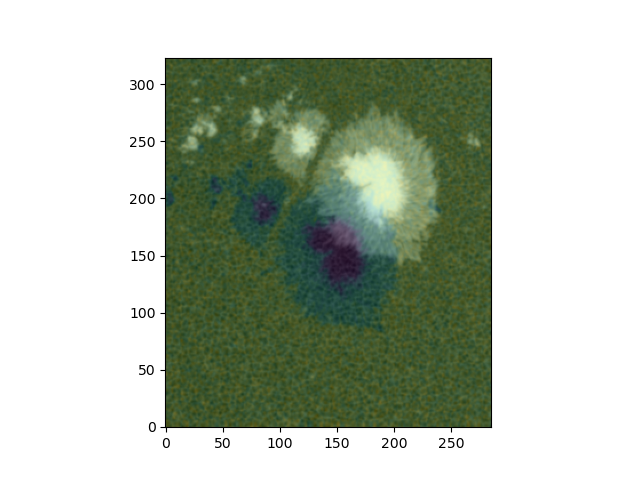

In [117]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

#plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_SP_img, origin='lower')
ax1.imshow(HMI_img, origin='lower', cmap='Greys', alpha=0.7)
#ax2.imshow(HMI_img_pad, origin='lower', cmap='Greys', alpha=1)

## Perform the 1st coalignment

In [43]:
# Use the sunpy coalignment routine to get an initial idea where the degraded Hinode data
# should be on the padded HMI map.  
thisxyshift = coalignment.calculate_shift(HMI_img_pad, tmp_SP_img)
print(thisxyshift)

(<Quantity 179.91677376 pix>, <Quantity 154.84935329 pix>)


In [44]:
thisxyshift[0].value - pix_pad, thisxyshift[1].value - pix_pad 

(59.9167737559691, 34.84935329118858)

In [46]:
# Recrop the HMI data to account for the offset in the coordinates.
hmi_index_x_new = np.around(hmi_index_x+(thisxyshift[1].value-pix_pad)).astype(int)
hmi_index_y_new = np.around(hmi_index_y+(thisxyshift[0].value-pix_pad)).astype(int)

HMI_img = lvl1_c_HMI.data[0,0, hmi_index_y_new[0]:hmi_index_y_new[1], \
                                    hmi_index_x_new[0]:hmi_index_x_new[1]]

In [47]:
hmi_index_x_new - hmi_index_x, hmi_index_y_new - hmi_index_y 

(array([35, 35]), array([60, 60]))

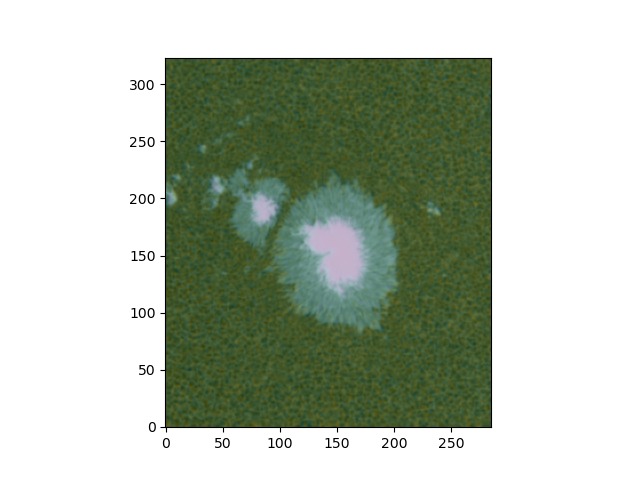

In [114]:
# Plot the maps to visually test the alignment.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_SP_img, origin='lower')
ax1.imshow(HMI_img, origin='lower', cmap='Greys', alpha=0.7)


## Reproject the WCS enabled objects.

### Modify Hinode SP WCS 

There are two ways to perform a translation of the WCS: 

1. Modify the crval values that save the center location in the real world system (e.g. Helioprojective)
To implement this we convert the offsets from HMI pixels to offsets in real world coordinates.

2. Modify the crpix value that save the center location in pixel units.
The Hinode/SP plate scale is different from SDO/HMI and the cross-correlation is computed in HMI pixels.
To implement this we have to perform an extra step of converting from real world coordinates into SP pixels.

Here we demonstrate the first solution.

In [56]:
print('Spatial axis increments: ', lvl1_c_HMI.wcs.wcs.cdelt[0:2], lvl1_c_HMI.wcs.world_axis_units[0:2])
hmi_xy_shift = [thisxyshift[1].value - pix_pad, thisxyshift[0].value - pix_pad]
print('Offsets in world units: ', hmi_xy_shift*lvl1_c_HMI.wcs.wcs.cdelt[0:2], lvl1_c_HMI.wcs.world_axis_units[0:2])

Spatial axis increments:  [0.0001401 0.0001401] ['deg', 'deg']
Offsets in world units:  [0.00488223 0.00839406] ['deg', 'deg']


In [118]:
# Calculate the 
new_cen = lvl1_c_SP.wcs.wcs.crval[0:2] + lvl1_c_HMI.wcs.wcs.cdelt[0:2]*hmi_xy_shift

In [119]:
# Create a copy of the WCS object to modify
# Crop should be the the last step applied.
target_wcs = astropy.wcs.WCS(lvl1_c_SP.wcs.to_header())
# Apply the translation.
target_wcs.wcs.crval[0:2] += lvl1_c_HMI.wcs.wcs.cdelt[0:2]*hmi_xy_shift
print(target_wcs)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
CRVAL : 0.040983064634902235  0.019671281815700825  6.30208e-07  0.0  
CRPIX : 243.0  256.5  56.5  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 8.2538888888889e-05  8.8882777777778e-05  2.1549e-12  1.0  
NAXIS : 0  0


In [61]:
# Make a new object with the updated WCS
lvl1_c_SP_1 = stokespy.StokesCube(lvl1_c_SP.data, target_wcs)
lvl2_c_SP_1 = stokespy.MagVectorCube(lvl2_c_SP.data, target_wcs, magnetic_params=lvl2_c_SP.magnetic_axis)


In [70]:
lvl1_c_SP_1.wcs, lvl1_c_SP.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.040983064634902235  0.019671281815700825  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.2538888888889e-05  8.8882777777778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  2.1549e-12  1.0  
 NAXIS : 0  0)

In [65]:
# Crop to the approximate coordinates that Hinode/SP is observing.

x_min, x_max = lvl1_c_SP_1.coord2_axis(0)[0].Tx.to(u.deg), lvl1_c_SP_1.coord2_axis(0)[-1].Tx.to(u.deg)
y_min, y_max = lvl1_c_SP_1.coord1_axis(0)[0].Ty.to(u.deg), lvl1_c_SP_1.coord1_axis(0)[-1].Ty.to(u.deg)

# Increase the size of the bounding box so the cross-correlation works better.
offset = 0*u.arcsec
bottom_left_skycoord = SkyCoord(Tx = x_min, Ty = y_min, frame = lvl1_c_HMI.meta['frame'])

top_right_skycoord = SkyCoord(Tx = x_max, Ty = y_max, frame = lvl1_c_HMI.meta['frame'])

#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

crop_HMI_map = lvl1_c_HMI.crop((bottom_left_skycoord, None, None), (top_right_skycoord, None, None))
print(crop_HMI_map.data.shape)

ix_0, wav0 =  0 6.3008840305e-07 m
ix_0, wav0 =  0 6.3008840305e-07 m
ix_0, wav0 =  0 6.173173e-07 m
ix_0, wav0 =  0 6.3008840305e-07 m
ix_0, wav0 =  0 6.3008840305e-07 m
ix_0, wav0 =  0 6.173173e-07 m


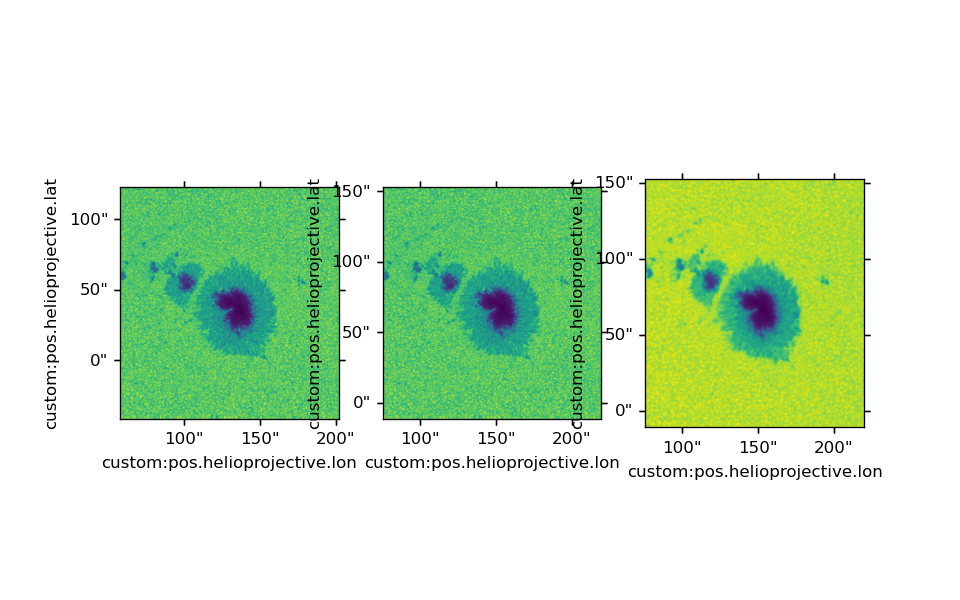

In [122]:
%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True)

fig = plt.figure(constrained_layout=False, figsize=(8,5), dpi=120)

ax1 = fig.add_subplot(131, projection=lvl1_c_SP.I_map(0).wcs)
ax2 = fig.add_subplot(132, projection=lvl1_c_SP_1.I_map(0).wcs)
ax3 = fig.add_subplot(133, projection=crop_HMI_map.I_map(0).wcs)
#ax2 = plt.subplot(122, projection=mag_fden_HMI_map[0,:,:].wcs)

#plt.subplots_adjust(wspace=0.4)

ax1.imshow(lvl1_c_SP.I_map(0).data, origin='lower')
ax2.imshow(lvl1_c_SP_1.I_map(0).data, origin='lower')
ax3.imshow(crop_HMI_map.I_map(0).data, origin='lower')
#ax2.imshow(mag_fden_HMI_map[0,:,:].data, origin='lower')

#lvl1_c_SP.I_map(0).plot(ax=ax1)
#lvl1_c_SP_1.I_map(0).plot(ax=ax2)
#crop_HMI_map.I_map(0).plot(ax=ax3)

#lvl.plot(ax=ax1)
#cropped_map.plot(ax=ax2)

In [124]:
# Test Sky coordinates

test_skycoord0 = SkyCoord(Tx = 131 * u.arcsec, Ty = 37 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])
test_skycoord1 = SkyCoord(Tx = 148 * u.arcsec, Ty = 67 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])
#test_skycoord1 = SkyCoord(Tx = 148 * u.arcsec, Ty = 67 * u.arcsec, \
#                               frame = lvl1_c_HMI.meta['frame'])

In [126]:
orig_test_ind = lvl1_c_SP[0,0,:,:].wcs.world_to_array_index(test_skycoord0)
reproj_test_ind = lvl1_c_SP_1[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
print('SP pixel original: ', orig_test_ind)
print(reproj_test_ind)
print(orig_test_ind[0] - reproj_test_ind[0], orig_test_ind[1] - reproj_test_ind[1])

SP pixel original:  (244, 245)
(244, 244)
0 1


In [99]:
# Calculate the array pix near test_SKYcoord1
HMI_test_ind = lvl1_c_HMI[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
cropped_test_ind = crop_HMI_map[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
reproj_SP_test_ind = lvl1_c_SP_1[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
print(HMI_test_ind)
print(cropped_test_ind)
print(reproj_SP_test_ind)
#print(orig_test_ind[0] - reproj_test_ind[0], orig_test_ind[1] - reproj_test_ind[1])

(2179, 2350)
(154, 143)
(244, 244)


In [293]:
coord_orig = orig_map.wcs.array_index_to_world_values(*orig_test_ind)
coord_shifted = reproj_map.wcs.array_index_to_world_values(*reproj_test_ind)
print('Original bottom left x,y: ', (coord_orig*u.deg).to(u.arcsecond))
print('Shifted bottom left x,y: ', (coord_shifted*u.deg).to(u.arcsecond))

Original bottom left x,y:  [130.85442001  36.918253  ] arcsec
Shifted bottom left x,y:  [113.07945012   6.30946021] arcsec


In [325]:
# Test the 1D profiles.

HMI_V = lvl1_c_HMI.V_profile(test_skycoord1)
SP_V = reproj_SP_map_1.V_profile(test_skycoord1)

In [315]:
HMI_V.meta,SP_V.meta

(OrderedDict([('frame',
               <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                   (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                   (75.77434791, -10.78032827)>),
              ('stokes', 'V'),
              ('x0_pix', 2358),
              ('y0_pix', 2179),
              ('x0', <Longitude 151.9301398 arcsec>),
              ('y0', <Latitude 66.88766824 arcsec>)]),
 OrderedDict([('frame',
               <Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
                   (75.53295834, -10.86755927)>),
              ('stokes', 'V'),
              ('x0_pix', 257),
              ('y0_pix', 243),
              ('x0', <Longitude 151.89792953 arcsec>),
              ('y0', <Latitude 66.88708572 arcsec>)]))

Text(0.5, 1.0, 'SDO/HMI $\\lambda$=617.3 nm')

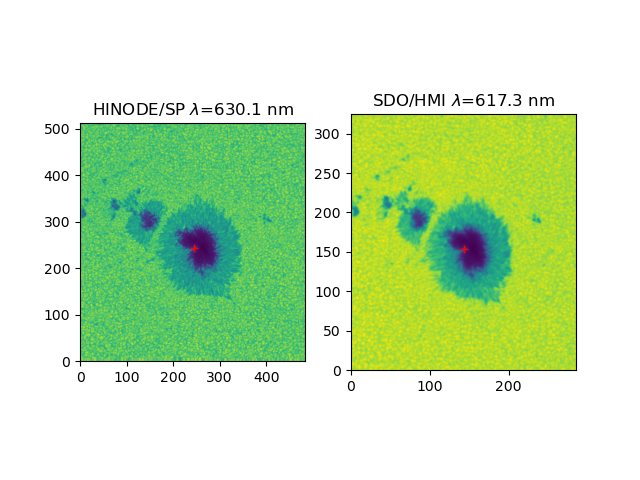

In [128]:
%matplotlib widget 

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
wav = 0
ax1.imshow(lvl1_c_SP_1.data[0,wav,:,:], origin='lower')
ax2.imshow(crop_HMI_map.data[0,wav,:,:], origin='lower')

#print(HMI_test_ind)
#print(cropped_test_ind)
#print(reproj_SP_test_ind)

ax1.plot(reproj_SP_test_ind[1], reproj_SP_test_ind[0], '+r')
ax2.plot(cropped_test_ind[1], cropped_test_ind[0], '+r')

ax1.set_title('HINODE/SP $\lambda$=' + 
              str(np.round(lvl1_c_SP_1.spectral_axis[wav].to(u.nm), 1)))
ax2.set_title('SDO/HMI $\lambda$=' + 
              str(np.round(crop_HMI_map.spectral_axis[wav].to(u.nm), 1)))

OrderedDict([('frame', <Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (75.63116115, -10.93775952)>), ('x0_pix', 244), ('y0_pix', 244), ('x0', <Longitude 148.13331264 arcsec>), ('y0', <Latitude 67.13686346 arcsec>)])
244 244


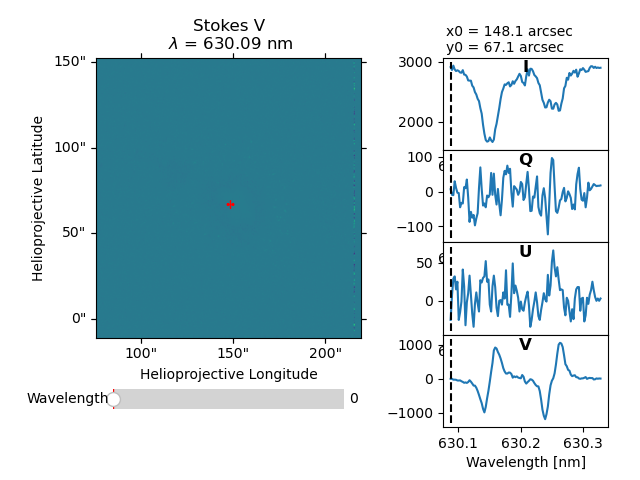

In [136]:
%matplotlib widget

lvl1_c_SP_1.plot(coords=test_skycoord1, context=3)

OrderedDict([('frame', <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
    (75.77434791, -10.78032827)>), ('x0_pix', 143), ('y0_pix', 154), ('x0', <Longitude 147.89539672 arcsec>), ('y0', <Latitude 66.88850955 arcsec>)])
143 154


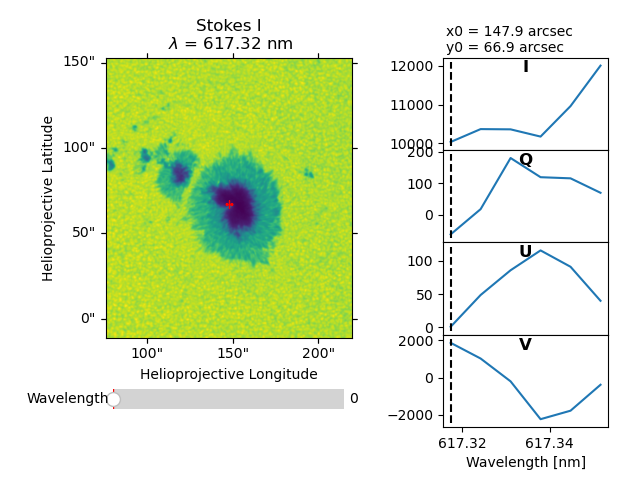

In [130]:
%matplotlib widget

crop_HMI_map.plot(coords=test_skycoord1, context=0)

ix_0, wav0 =  0 6.3008840305e-07 m
ix_0, wav0 =  0 6.3008840305e-07 m


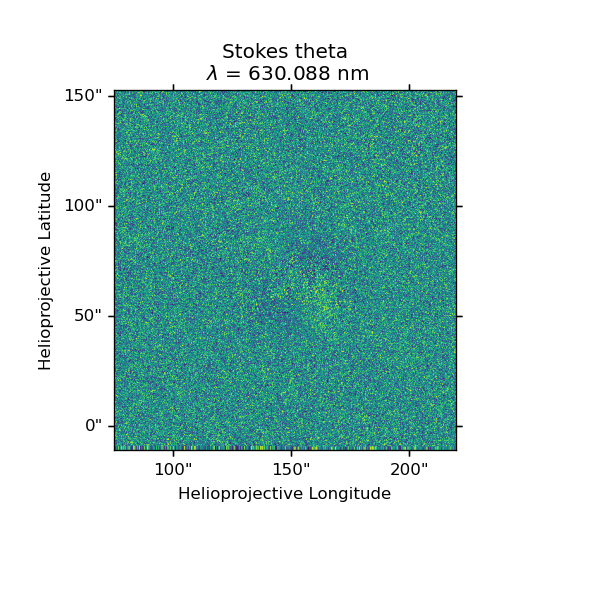

In [144]:
%matplotlib widget

lvl1_c_SP_1.theta_map(0).plot()

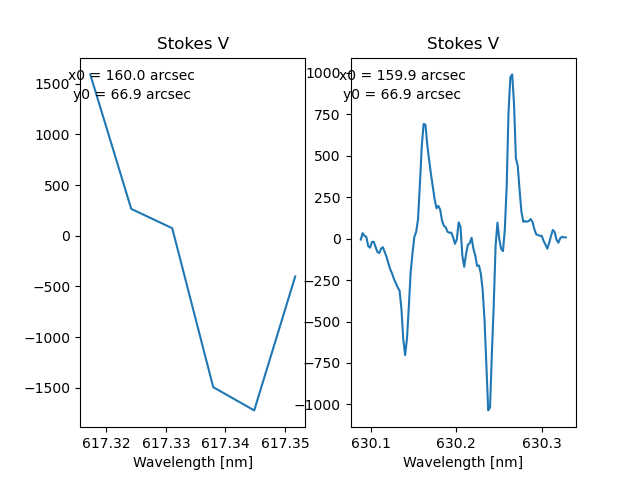

In [328]:
%matplotlib widget

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

HMI_V.plot(ax=ax1)
SP_V.plot(ax=ax2)

In [119]:
cropped_map.data.shape

(325, 286)

In [120]:
524-286, 563-325

(238, 238)

In [46]:
cropped_map.data.shape

(563, 524)

In [45]:
m_SP.data.shape

(512, 485)

In [141]:
%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(121, projection=m_SP.wcs)
ax2 = plt.subplot(122, projection=cropped_map.wcs)

plt.subplots_adjust(wspace=0.4)

m_SP.plot(ax=ax1)
cropped_map.plot(ax=ax2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Co-aling the cutouts.

In [105]:
# Degrade the Hinode data with a Gaussian and rescale to the same pixel size as HMI.
# The 1.3 sigma for the Gaussian is not actually chosen based on any physical parameters,
# just such that the Hinode map looks ~ish like HMI.
tmp_hinode_data_0 = ndimage.gaussian_filter(m_SP.data,1.3)
tmp_hinode_data = ndimage.zoom(tmp_hinode_data_0, \
                                [(hmi_index_y[1]-hmi_index_y[0])/tmp_hinode_data_0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_hinode_data_0.shape[1]])

print('Zoom values: ', [(hmi_index_y[1]-hmi_index_y[0])/tmp_hinode_data_0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_hinode_data_0.shape[1]])

Zoom values:  [0.6328125, 0.5876288659793815]


In [108]:
hmi_index_x[1]-hmi_index_x[0], hmi_index_x[1],hmi_index_x[0]

(285, 2457, 2172)

In [110]:
tmp_hinode_data_0.shape, tmp_hinode_data.shape

((512, 485), (324, 285))

In [112]:
cropped_map.data.shape

(563, 524)

In [116]:
# Use the sunpy coalignment routine to get an initial idea where the degraded Hinode data
# should be on the padded HMI map.  
thisxyshift = coalignment.calculate_shift(cropped_map.data, tmp_hinode_data)
print(thisxyshift)

In [157]:
thisxyshift[0].value - pix_pad, thisxyshift[1].value - pix_pad 

(59.927589291702304, 34.86777276427284)

In [216]:
hmi_index_x_new = np.around(hmi_index_x+(thisxyshift[1].value-pix_pad)).astype(int)
hmi_index_y_new = np.around(hmi_index_y+(thisxyshift[0].value-pix_pad)).astype(int)
hmi_data = m_HMI.data[hmi_index_y_new[0]:hmi_index_y_new[1],hmi_index_x_new[0]:hmi_index_x_new[1]]


In [217]:
hmi_index_x_new - hmi_index_x, hmi_index_y_new - hmi_index_y 

(array([35, 35]), array([60, 60]))

In [140]:
hmi_data.shape

(324, 285)

In [218]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_hinode_data, origin='lower')
ax1.imshow(hmi_data, origin='lower', cmap='Greys', alpha=0.7)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Perform the final cross-correlation

In [219]:
# Now use the FFT image shift routine for better precision and
# create the final HMI cutout. 
xshift, yshift = get_image_shift(hmi_data, tmp_hinode_data)

hmi_index_x_new_final = hmi_index_x_new + xshift
hmi_index_y_new_final = hmi_index_y_new + yshift
hmi_data_final = m_HMI.data[hmi_index_y_new_final[0]:hmi_index_y_new_final[1],
                            hmi_index_x_new_final[0]:hmi_index_x_new_final[1]]

In [205]:
hmi_index_x_new_final, hmi_index_y_new_final

(array([2207, 2492]), array([2025, 2349]))

In [220]:
xshift, yshift

(0, 0)

In [207]:
hmi_index_x_new_final - hmi_index_x, hmi_index_y_new_final - hmi_index_y

(array([35, 35]), array([60, 60]))

In [211]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_hinode_data, origin='lower')
ax1.imshow(hmi_data_final, origin='lower', cmap='Greys', alpha=0.5)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [144]:
tmp_hinode_data.shape, hmi_data.shape

((324, 285), (324, 285))

In [138]:
m_HMI.data.shape

(4098, 4098)

In [134]:
hmi_index_x

array([2172, 2457])

In [131]:
m_HMI.wcs

SlicedLowLevelWCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None

World Dim  Axis Name  Physical Type                   Units
        0  None       custom:pos.helioprojective.lon  deg
        1  None       custom:pos.helioprojective.lat  deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes

In [167]:
%matplotlib widget

# Plot a cropped portion of the map.
#bottom_left_skycoord = SkyCoord(Tx= -500 * u.arcsec, Ty = -80 * u.arcsec, frame=m_HMI.meta['frame'])
#top_right_skycoord = SkyCoord(Tx= -350* u.arcsec, Ty=  80* u.arcsec, frame=m_HMI.meta['frame'])

#lv1_c_SP.coord1_axis(0)[0], lv1_c_SP.coord2_axis(512)[-1]

#bottom_left_skycoord = lv1_c_SP.coord1_axis(0)[0]
#top_right_skycoord = lv1_c_SP.coord2_axis(512)[-1]
#bottom_left_skycoord.frame.observer = m_HMI.meta['frame']
#bottom_right_skycoord.frame.observer = m_HMI.meta['frame']

bottom_left_skycoord = SkyCoord(Tx = lv1_c_SP.coord1_axis(0)[0].Tx, \
                               Ty = lv1_c_SP.coord1_axis(0)[0].Ty, \
                               frame = m_HMI.meta['frame'])

top_right_skycoord = SkyCoord(Tx = lv1_c_SP.coord2_axis(512)[-1].Tx, \
                               Ty = lv1_c_SP.coord1_axis(512)[-1].Ty, \
                               frame = m_HMI.meta['frame'])


#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = m_HMI.crop((bottom_left_skycoord), (top_right_skycoord))

cropped_map.plot()

#m_HMI.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
%matplotlib widget

m_HMI.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [111]:
(7000*u.km/((1*u.AU).to(u.km)) * u.rad).to(u.arcsec)

<Quantity 9.65156547 arcsec>

In [106]:
m_HMI.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                  (1028.22718646, 1033.93563675)>),
             ('stokes', 'I'),
             ('wav0', <Quantity 6.173173e-07 m>),
             ('wav1', None)])

In [82]:
# Plot a cropped portion of the map.
%matplotlib widget

ex_map[0:2000, 0:2000].plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
level1_cube.frame

<Helioprojective Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.06217846, 5.58266211, 1.51876022e+11)>): (Tx, Ty) in arcsec
    (1027.65813226, 1034.34957067)>

In [85]:
# Plot a cropped portion of the map.
%matplotlib widget

bottom_left_skycoord = SkyCoord(Tx= -700 * u.arcsec, Ty= -700 * u.arcsec, frame=ex_map.meta['frame'])
top_right_skycoord = SkyCoord(Tx= 700* u.arcsec, Ty= 700 * u.arcsec, frame=ex_map.meta['frame'])

#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = ex_map.crop((bottom_left_skycoord), (top_right_skycoord))

cropped_map.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
# High level coordinate objects must be wrapped in tuples.

wav0 = 6.1733 * 1.e-7 * u.m
#wav1 = 6.1736 * 1.e-7 * u.m
wav1 = 6.17334 * 1.e-7 * u.m

cropped_cube = level1_cube.crop((bottom_left_skycoord,wav0,None), 
                                  (top_right_skycoord,wav1,None))

In [100]:
level1_cube.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TODO1: implement <class 'stokespy.stokespy.StokesCube'>.plot()


## Test 1d profiles

In [36]:
# Choose coordinates
Tx = 200 * u.arcsec
Ty = 700 * u.arcsec

In [37]:
# Test a simple list
oo = lv1_c_HMI.I_profile([Tx, Ty])

oo.plot(u.AA)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [90]:
# Test a coordinate object without a frame.
profile_coords = SkyCoord(Tx, Ty)
oo = level1_cube.I_profile(profile_coords)

In [91]:
%matplotlib widget

oo.plot(u.m)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
# Test with SkyCoord object with frame.
profile_coords = SkyCoord(Tx=Tx, Ty=Ty, frame=level1_cube.meta['frame'])
oo = level1_cube.I_profile(profile_coords)

#print(oo.meta)

In [93]:
%matplotlib widget

oo.plot(u.AA)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
oo.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06217846, 5.58266211, 1.51876022e+11)>): (Tx, Ty) in arcsec
                  (1027.65813226, 1034.34957067)>),
             ('stokes', 'L'),
             ('x0_i', 1641),
             ('y0_i', 663),
             ('x0', <Longitude 200.0490688 arcsec>),
             ('y0', <Latitude 699.9840748 arcsec>)])

In [70]:
level1_cube.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06217846, 5.58266211, 1.51876022e+11)>): (Tx, Ty) in arcsec
                  (1027.65813226, 1034.34957067)>)])

# Test the magnetic field maps

In [53]:
# StokesPy cube with inversion results.
level2_cube = stokespy.MagVectorCube(level2_data, level2_wcs)

print(level2_cube.data.shape)

(3, 4096, 4096)


In [54]:
tt = level2_cube.B

In [60]:
%matplotlib widget

tt[0:2000,0:2000].plot(vmin=0, vmax=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [56]:
ll = tt[0:2000,0:2000]

In [57]:
ll.meta

{'magnetic_param': 'B'}